Use the time series forecasting package released by Facebook to make predictions about future data trends based on regular and seasonal historical data. This is a relatively simple method to operate.

In [ ]:
!pip install prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


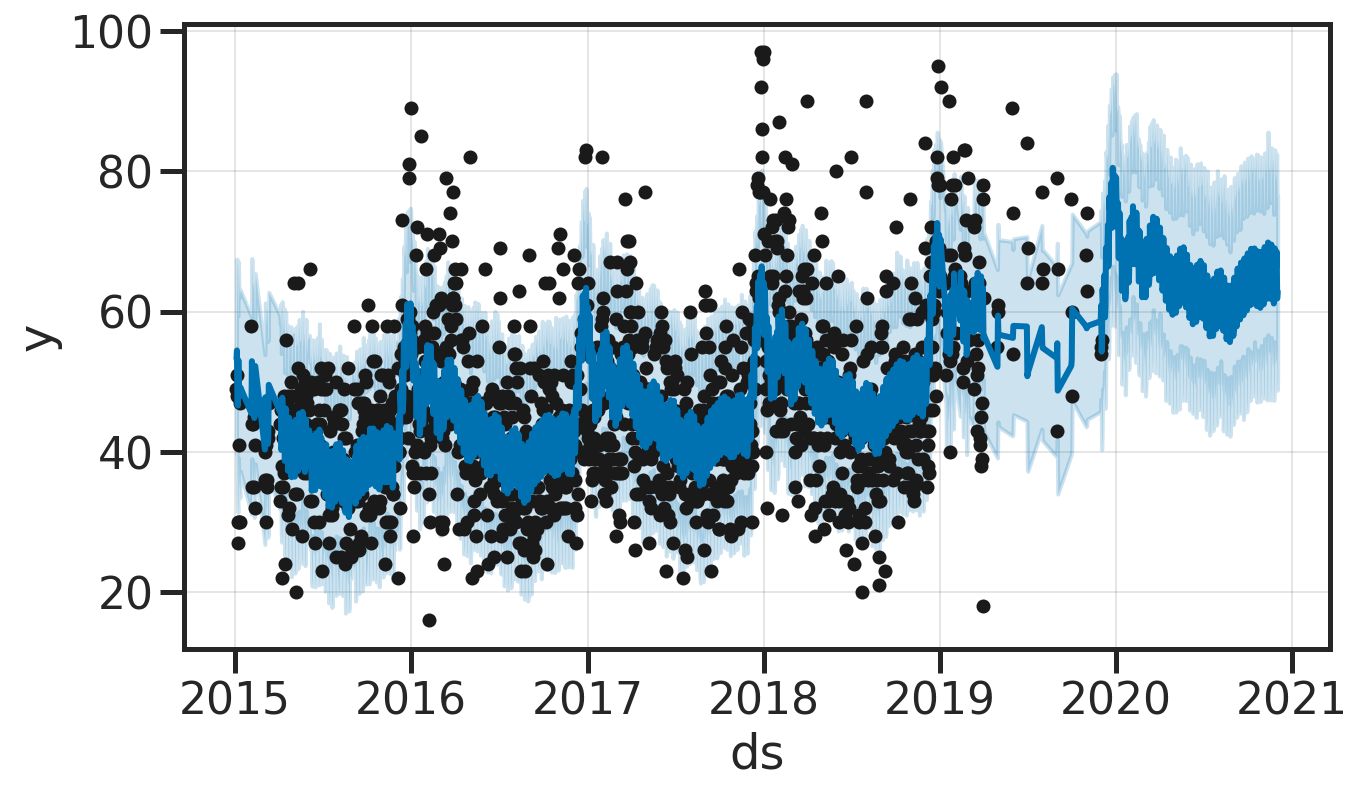

In [ ]:
import pandas as pd
df = pd.read_csv('TimeSeriesCourseworkDataPython.csv')
#df.head()
from prophet import Prophet
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods = 365)
forecast = model.predict(future)
figl = model.plot(forecast)


The black data points are the true values and the blue ones are the model's predicted trends, with different shades representing different confidence intervals.

In [ ]:
forecast[['ds','yhat','yhat_lower','yhat_upper']]

#01-04-2019 63
#02-04-2019 56
#03-04-2019 57


,ds,yhat,yhat_lower,yhat_upper
0,2015-01-04,53.26927,39.70760,65.71934
1,2015-01-05,54.45365,41.41981,67.47115
2,2015-01-06,46.73827,32.70322,59.77253
3,2015-01-07,46.59234,31.36927,59.37407
4,2015-01-08,53.06957,39.16409,67.09684
...,...,...,...,...
1821,2020-11-28,66.02395,53.31232,78.69306
1822,2020-11-29,66.38612,52.58328,79.61060
1823,2020-11-30,68.52126,54.80191,82.43542
1824,2020-12-01,61.86260,48.77227,76.26001


Building an ARIMA model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


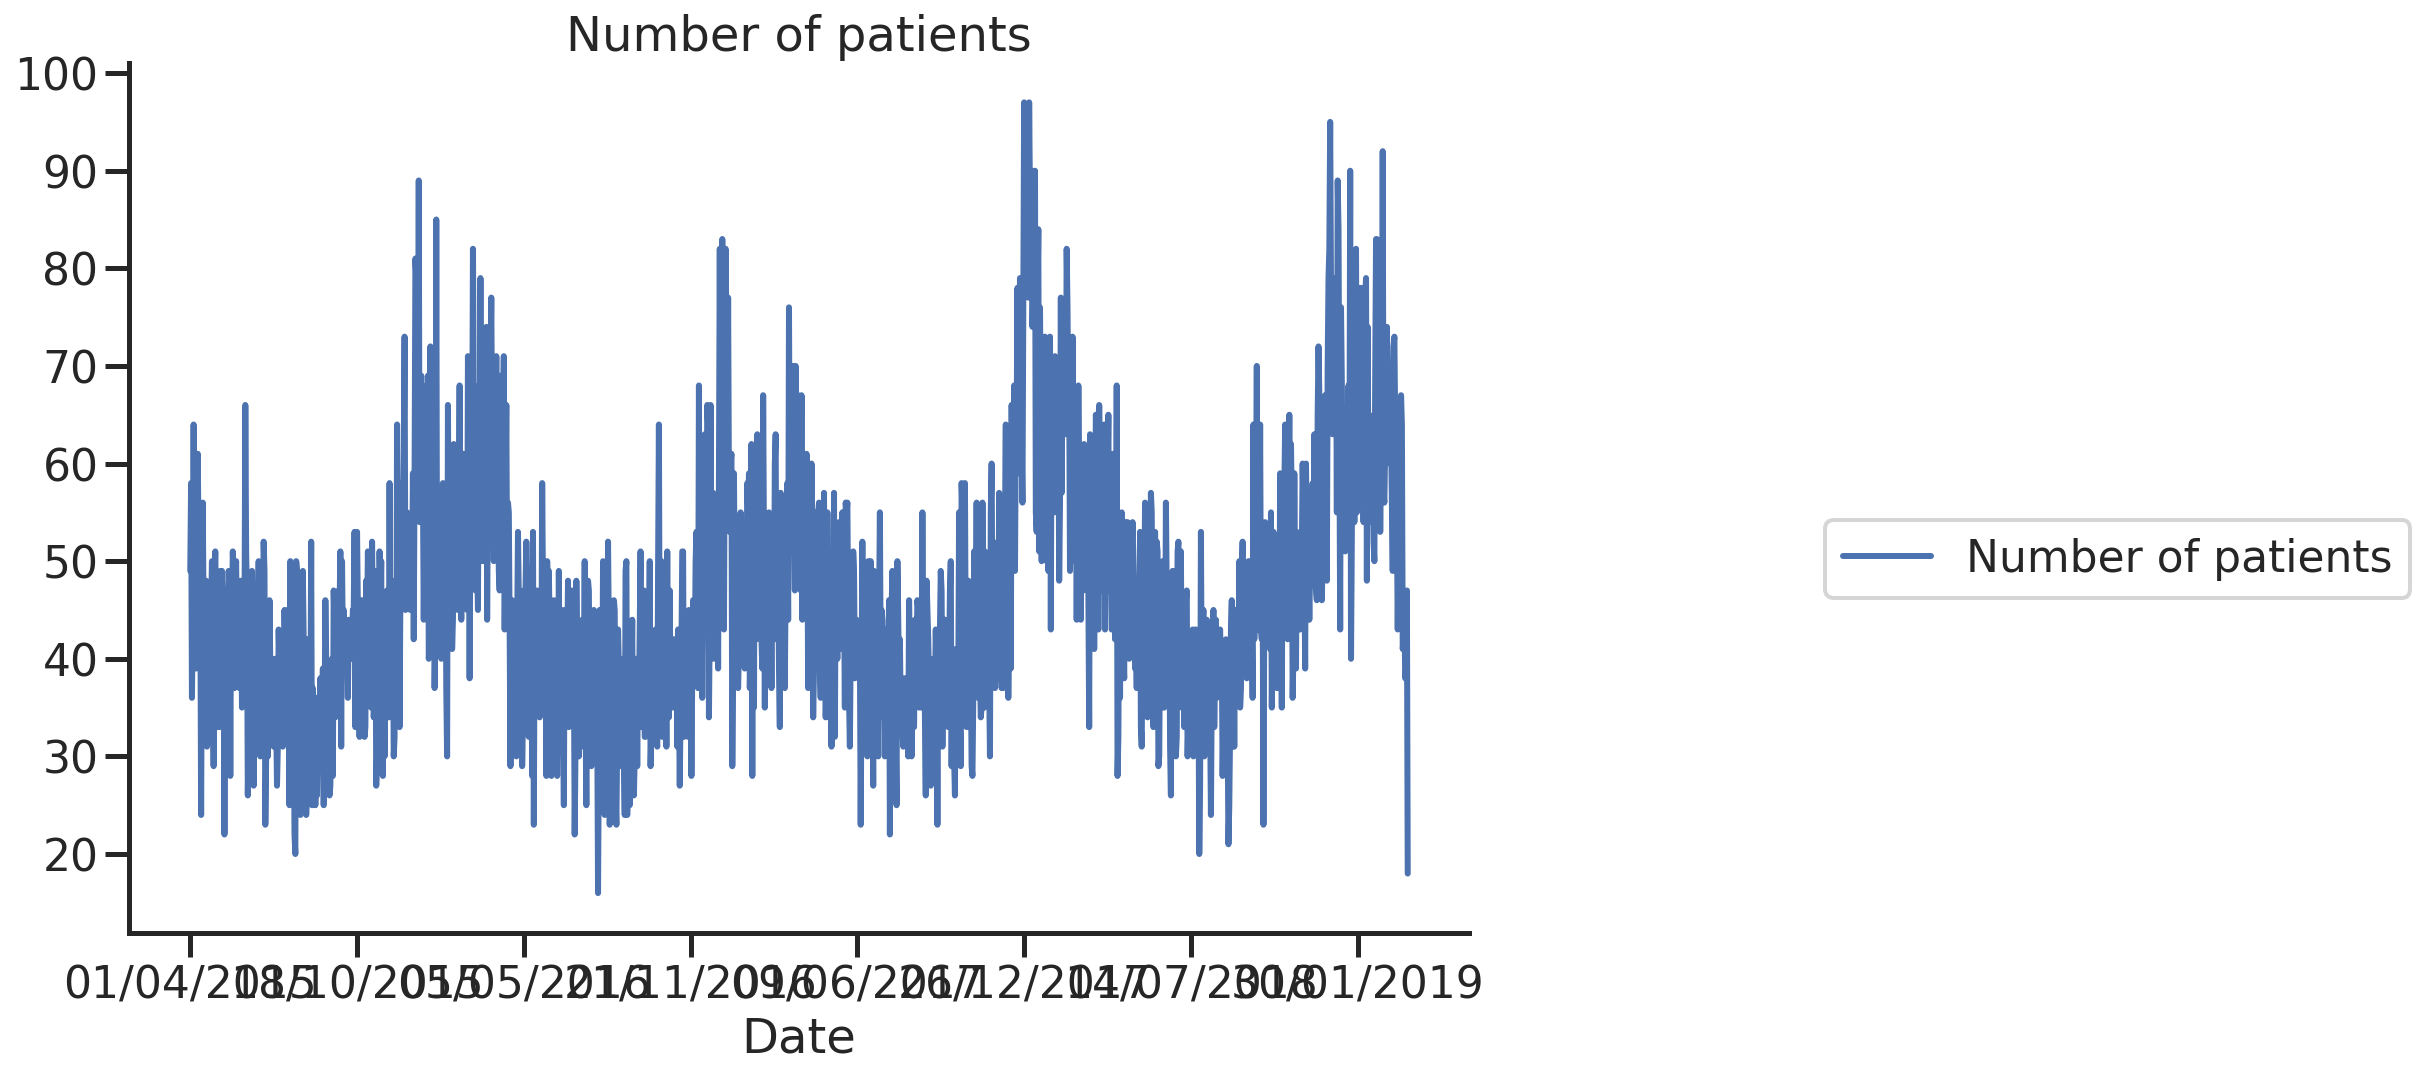

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
 
from __future__ import absolute_import, division, print_function
import sys
import os
from pandas import read_csv
import pandas as pd
import numpy as np
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib.pylab as plt
import seaborn as sns

df = read_csv('TimeSeriesCourseworkData21_22.csv', header=0, index_col=0)
df.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Number of patients")
sns.despine()


The ARIMA model requires the time series to be smooth. Therefore, when you get a non-stationary time series, the first thing to do is to do the difference of the time series until you get a stationary time series. If you have to differ the time series d times to get a smooth series, then you can use the ARIMA(p,d,q) model, where d is the number of differences.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2267b82710>,
      dtype=object)

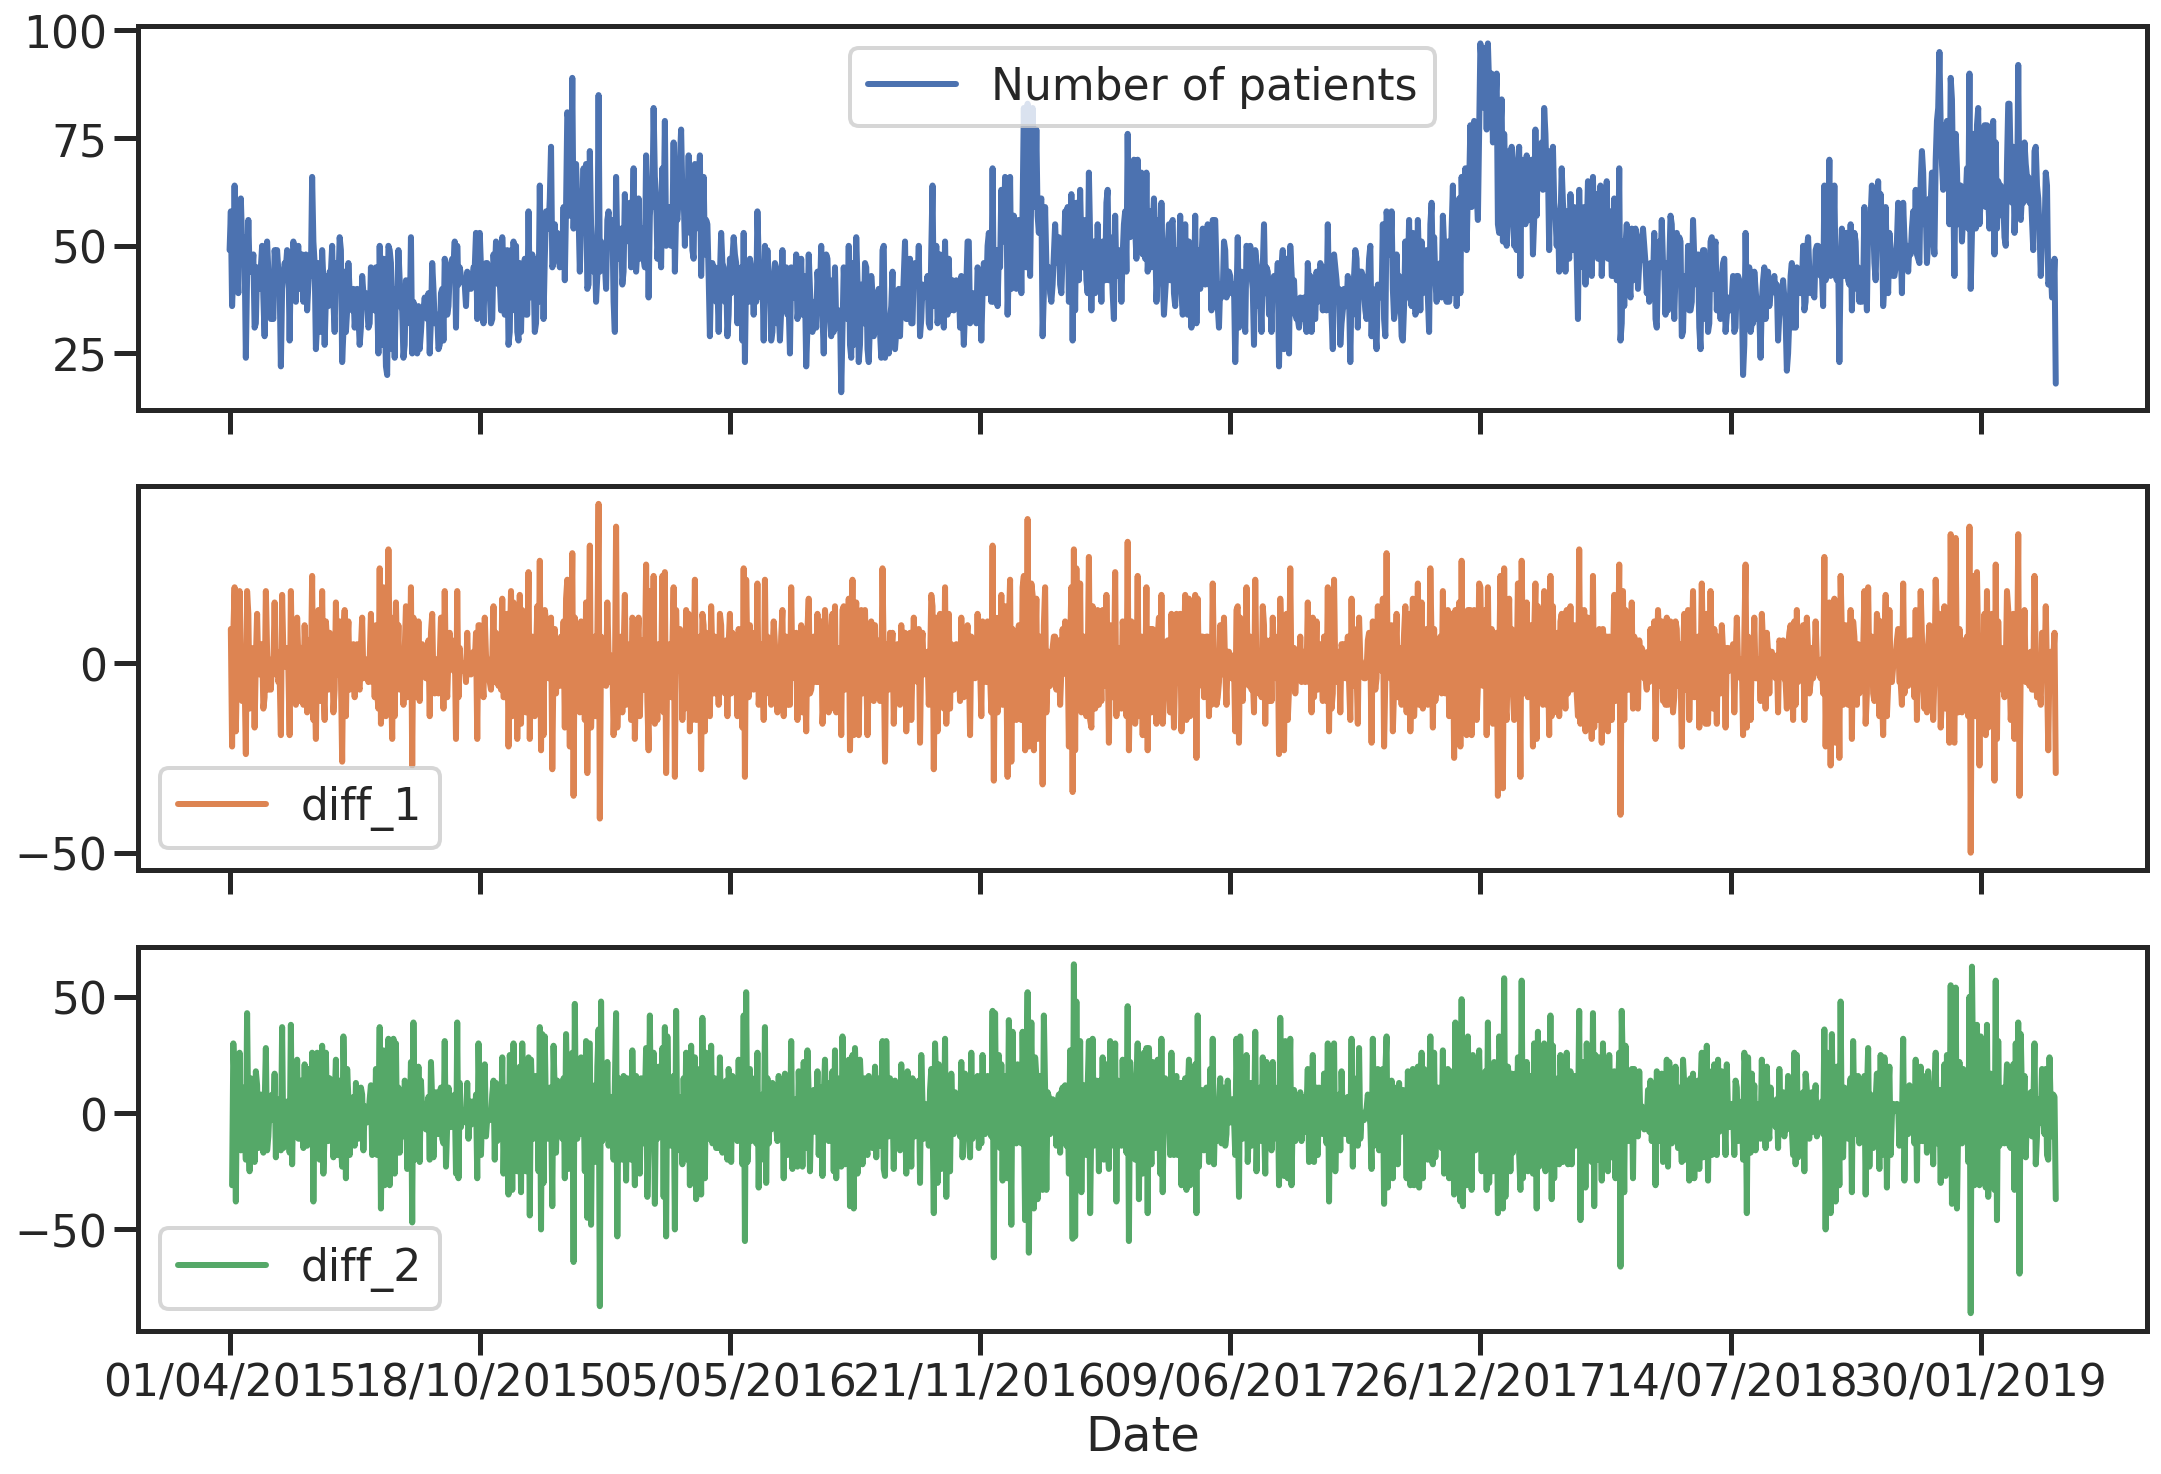

In [ ]:
df['diff_1'] = df['Number of patients'].diff(1)#Find the difference value, first order difference.
 
df['diff_2'] = df['diff_1'].diff(1)#Then find the difference, second order difference.
 
df.plot(subplots=True, figsize=(18, 12))

In [ ]:
del df['diff_2']
del df['diff_1']
df.head()
print(type(df))

<class 'pandas.core.frame.DataFrame'>


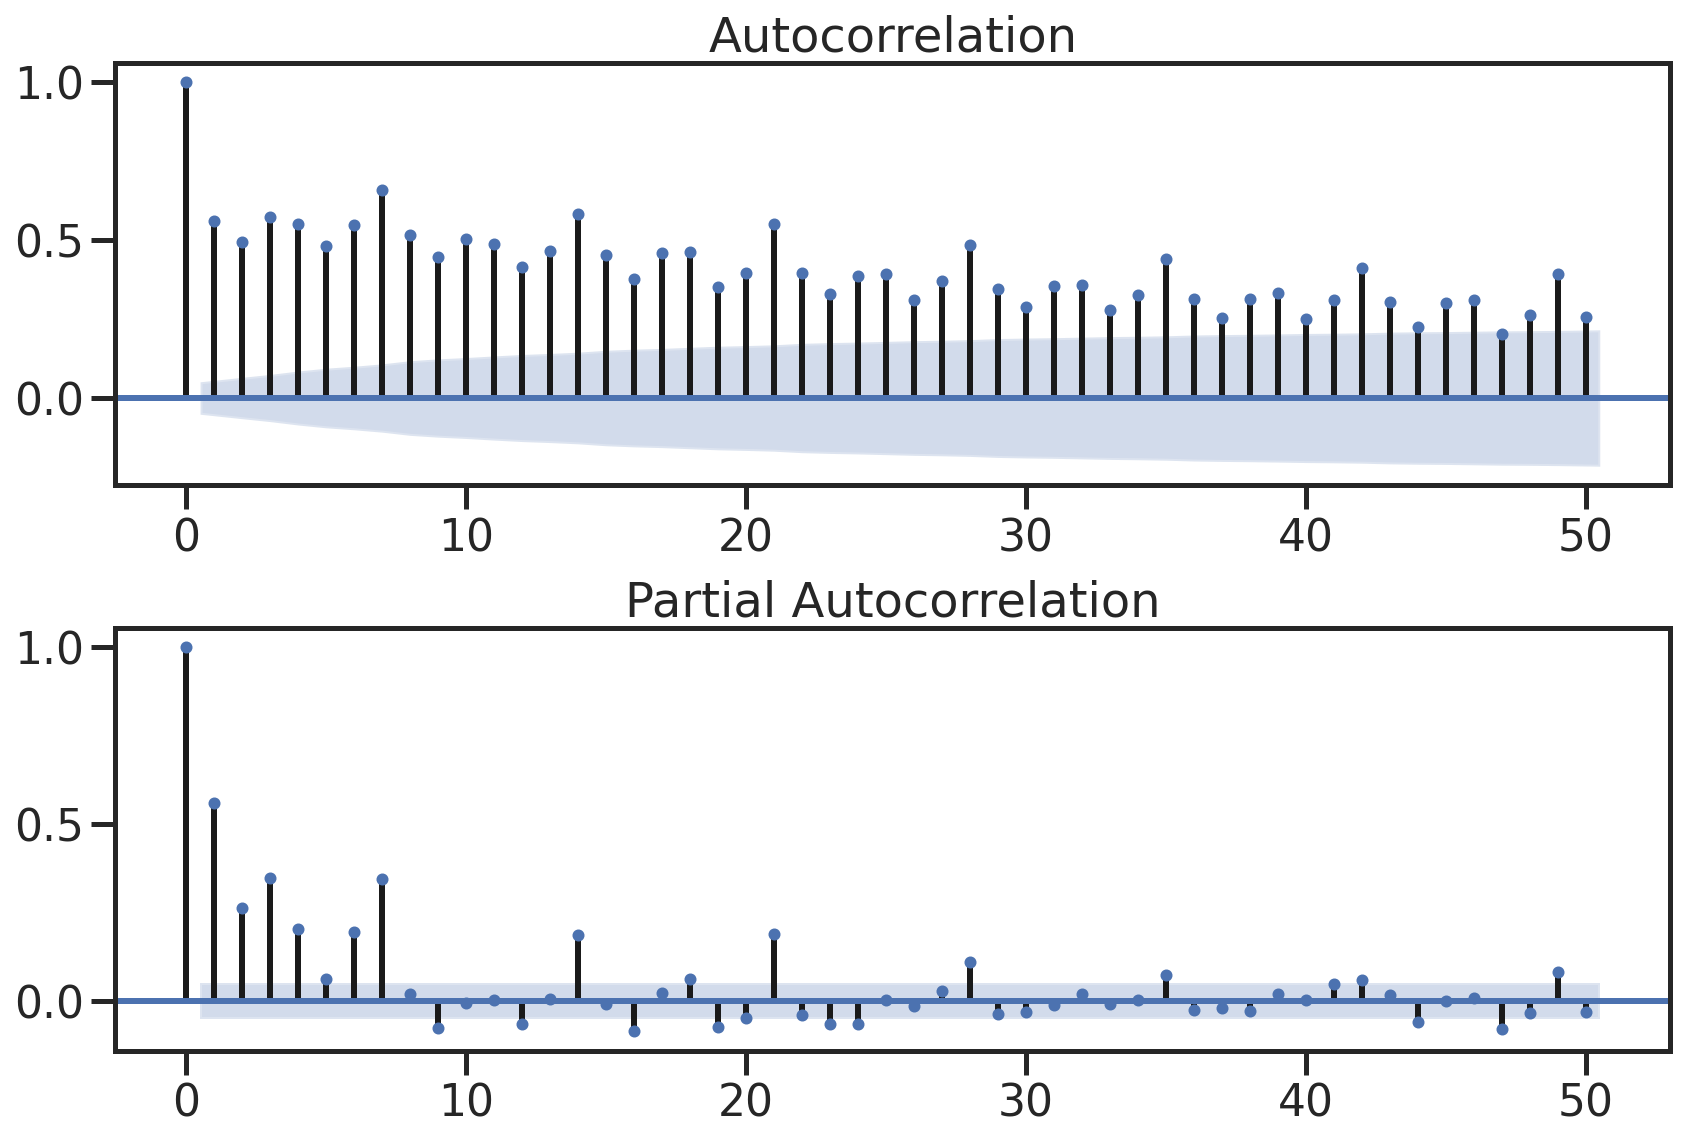

In [ ]:
fig = plt.figure(figsize=(12,8))
#acf
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=50,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#pacf
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=50, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

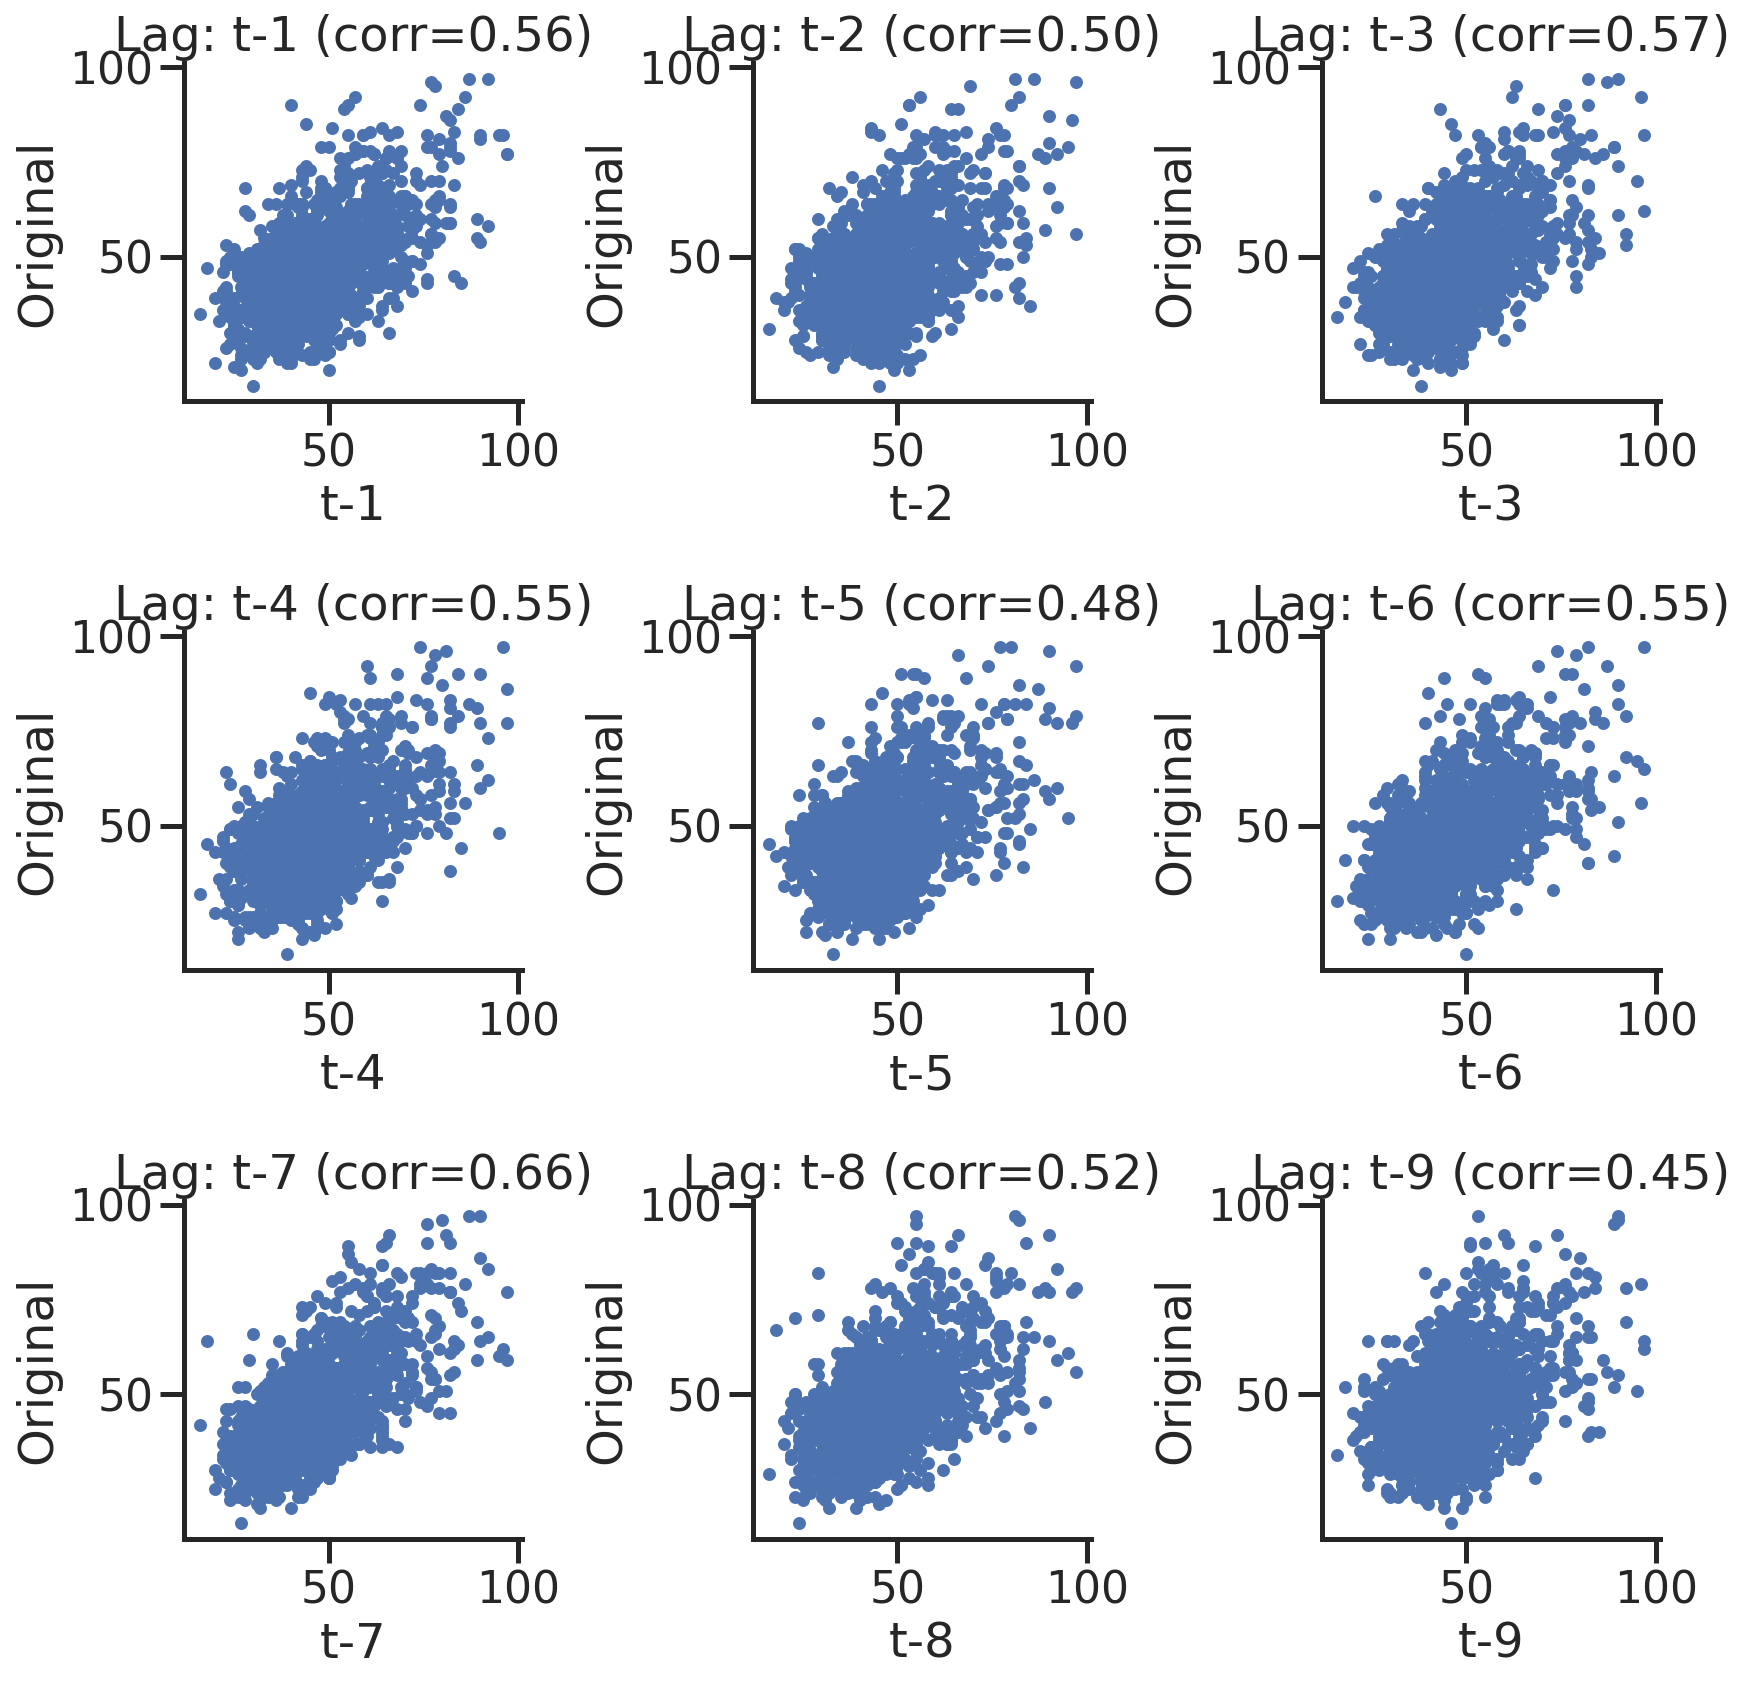

In [ ]:
#A scatter plot can also represent
lags=9
ncols=3
nrows=int(np.ceil(lags/ncols))
 
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
 
for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([df, df.shift(-lag)], axis=1,
                   keys=['y'] + [lag_str]).dropna())
 
    X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
    corr = X.corr().to_numpy()[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    sns.despine();
 
fig.tight_layout();

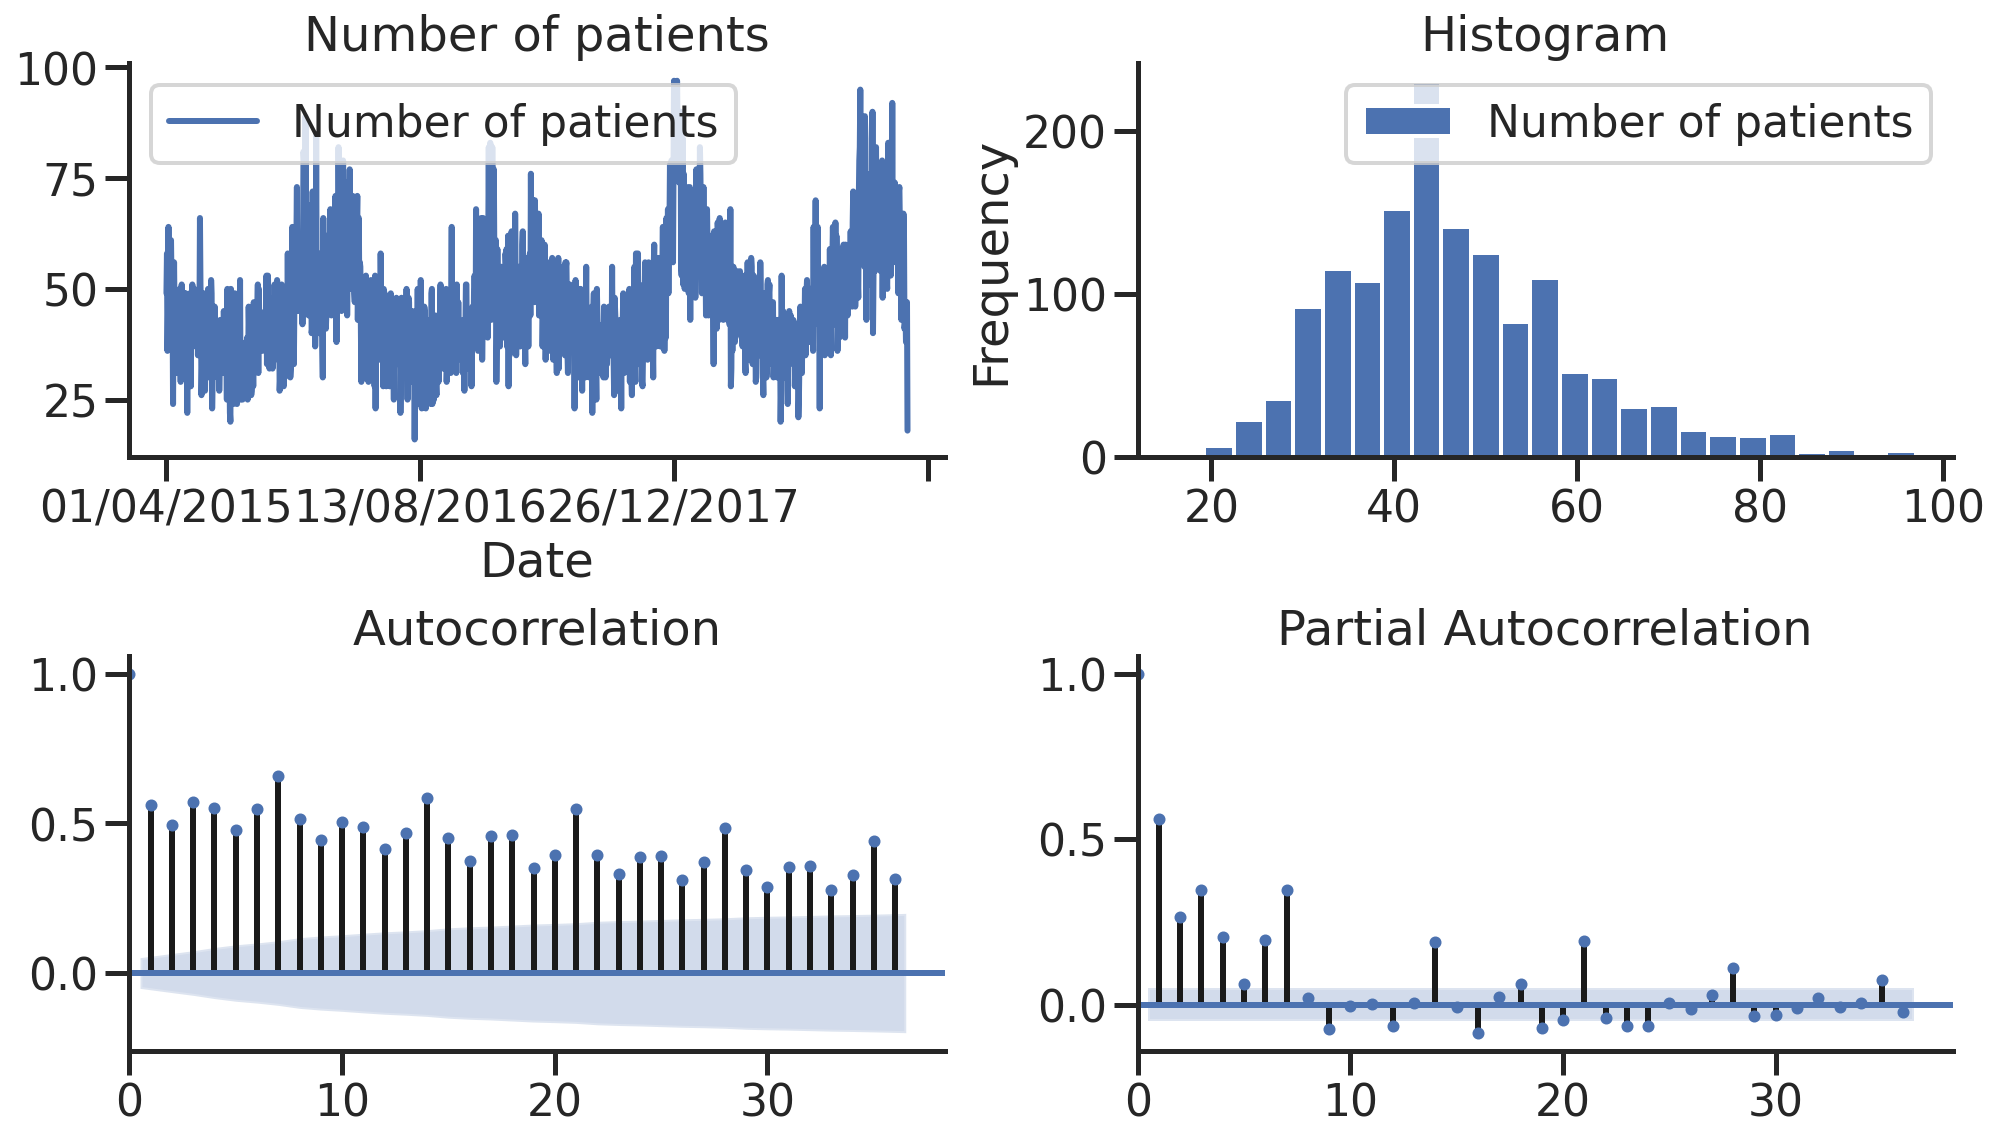

In [ ]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
     
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax
 
tsplot(df, title='Number of patients', lags=36);

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
 
# seaborn plotting style
sns.set(style='ticks', context='poster')
n_sample = df.shape[0]
print(df.shape)
print(df.head())

(1461, 1)
            Number of patients
Date                          
01/04/2015                  49
02/04/2015                  58
03/04/2015                  36
04/04/2015                  44
05/04/2015                  64


In [ ]:
# Create a training sample and testing sample before analyzing the series (7:3)

n_train=int(0.7*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = df.iloc[:n_train]['Number of patients']
ts_test = df.iloc[n_train:]['Number of patients']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())


(1023,)
(438,)
Training Series: 
 Date
13/01/2018    51
14/01/2018    76
15/01/2018    65
16/01/2018    50
17/01/2018    55
Name: Number of patients, dtype: int64 

Testing Series: 
 Date
18/01/2018    72
19/01/2018    64
20/01/2018    73
21/01/2018    65
22/01/2018    50
Name: Number of patients, dtype: int64


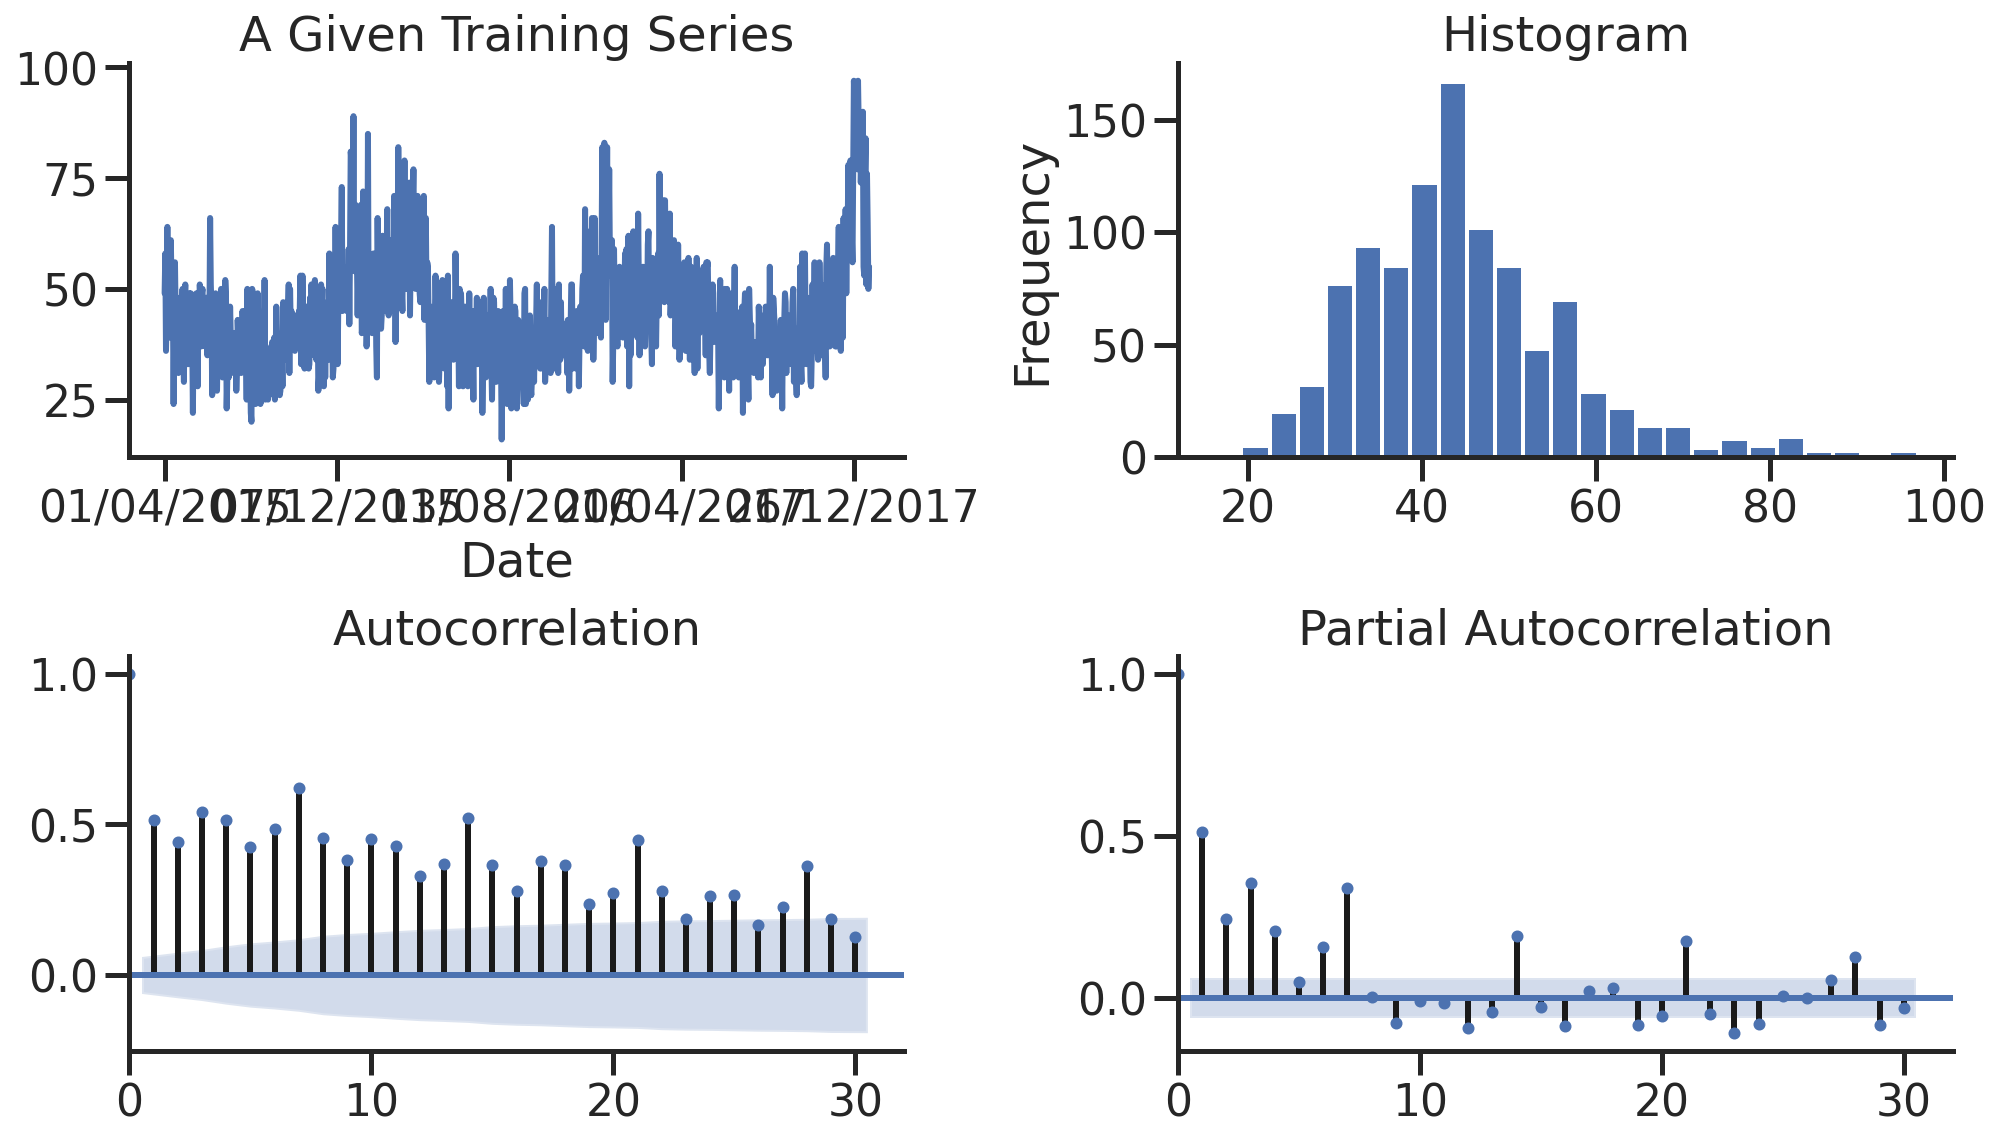

In [ ]:
tsplot(ts_train, title='A Given Training Series', lags=30);

In [ ]:
#Model Estimation
# Fit the model
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
model = sm.tsa.SARIMAX(ts_train, order=(5,1,7))#The three parameters p,d,q in the order
#model = sm.tsa.ARIMA(ts_train, order=(5, 1, 7))
model_results = model.fit()
print(model_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:     Number of patients   No. Observations:                 1021
Model:               SARIMAX(5, 1, 7)   Log Likelihood               -3586.733
Date:                Sat, 26 Mar 2022   AIC                           7199.467
Time:                        19:49:46   BIC                           7263.525
Sample:                             0   HQIC                          7223.790
                               - 1021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2178      0.027     -8.046      0.000      -0.271      -0.165
ar.L2         -0.6366      0.028    -22.550      0.000      -0.692      -0.581
ar.L3         -0.6003      0.034    -17.839      0.0

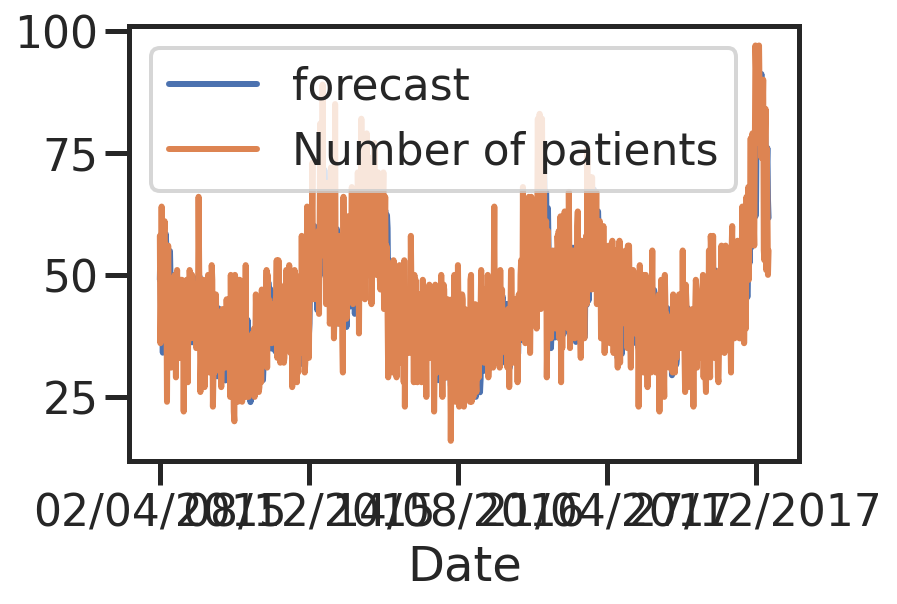

In [ ]:
model_results.plot_predict(dynamic=False)
plt.show()

In [ ]:
import itertools
#When multiple sets of values do not match, iterate through the sets to arrive at the best value
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4
 
# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
     
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

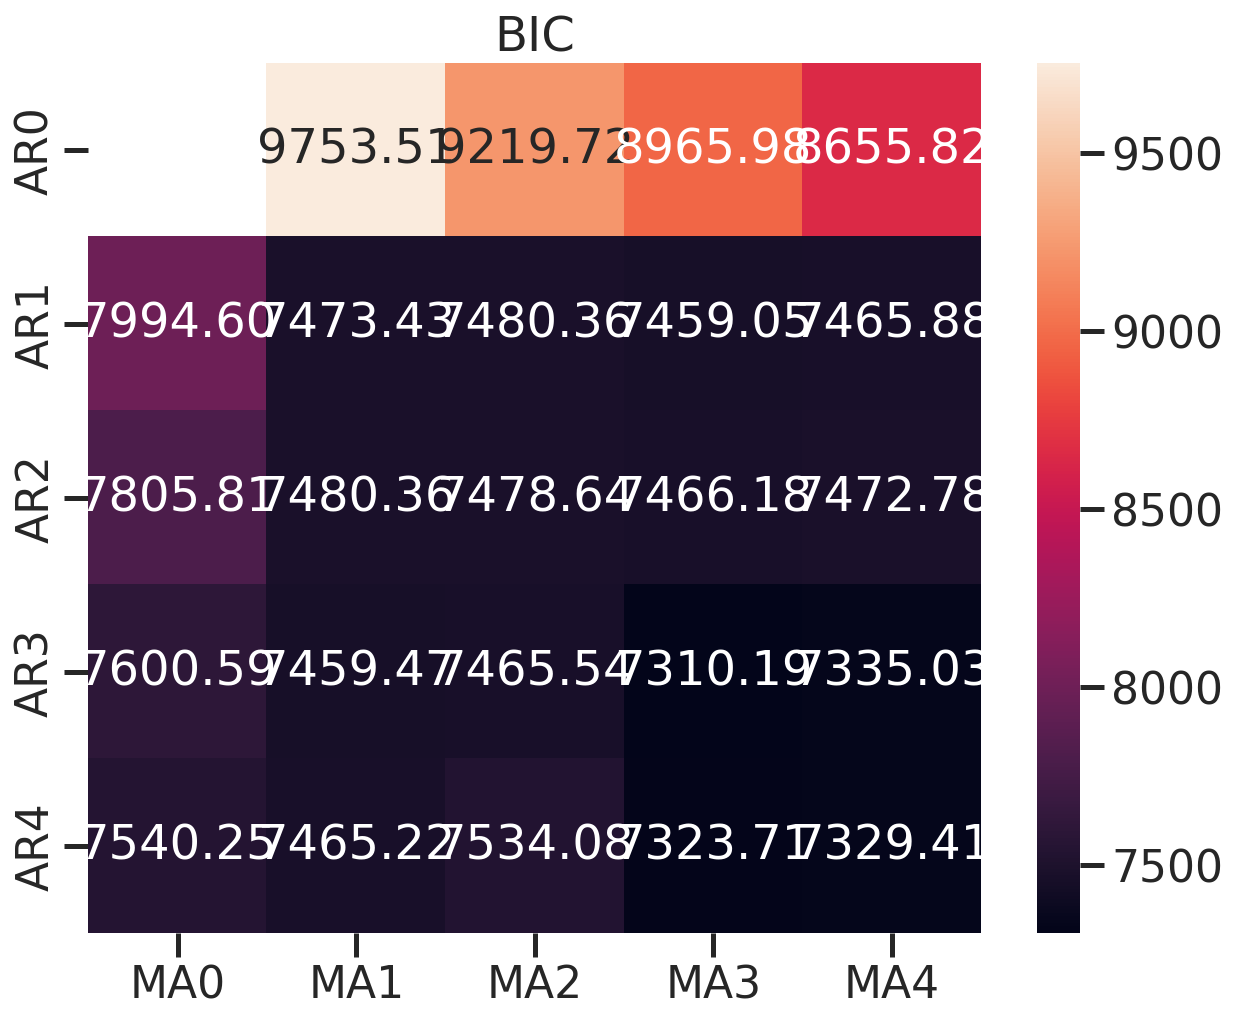

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [ ]:
# Alternative model selection method, limited to only searching AR and MA parameters
 
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC (3, 3)
BIC (3, 3)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


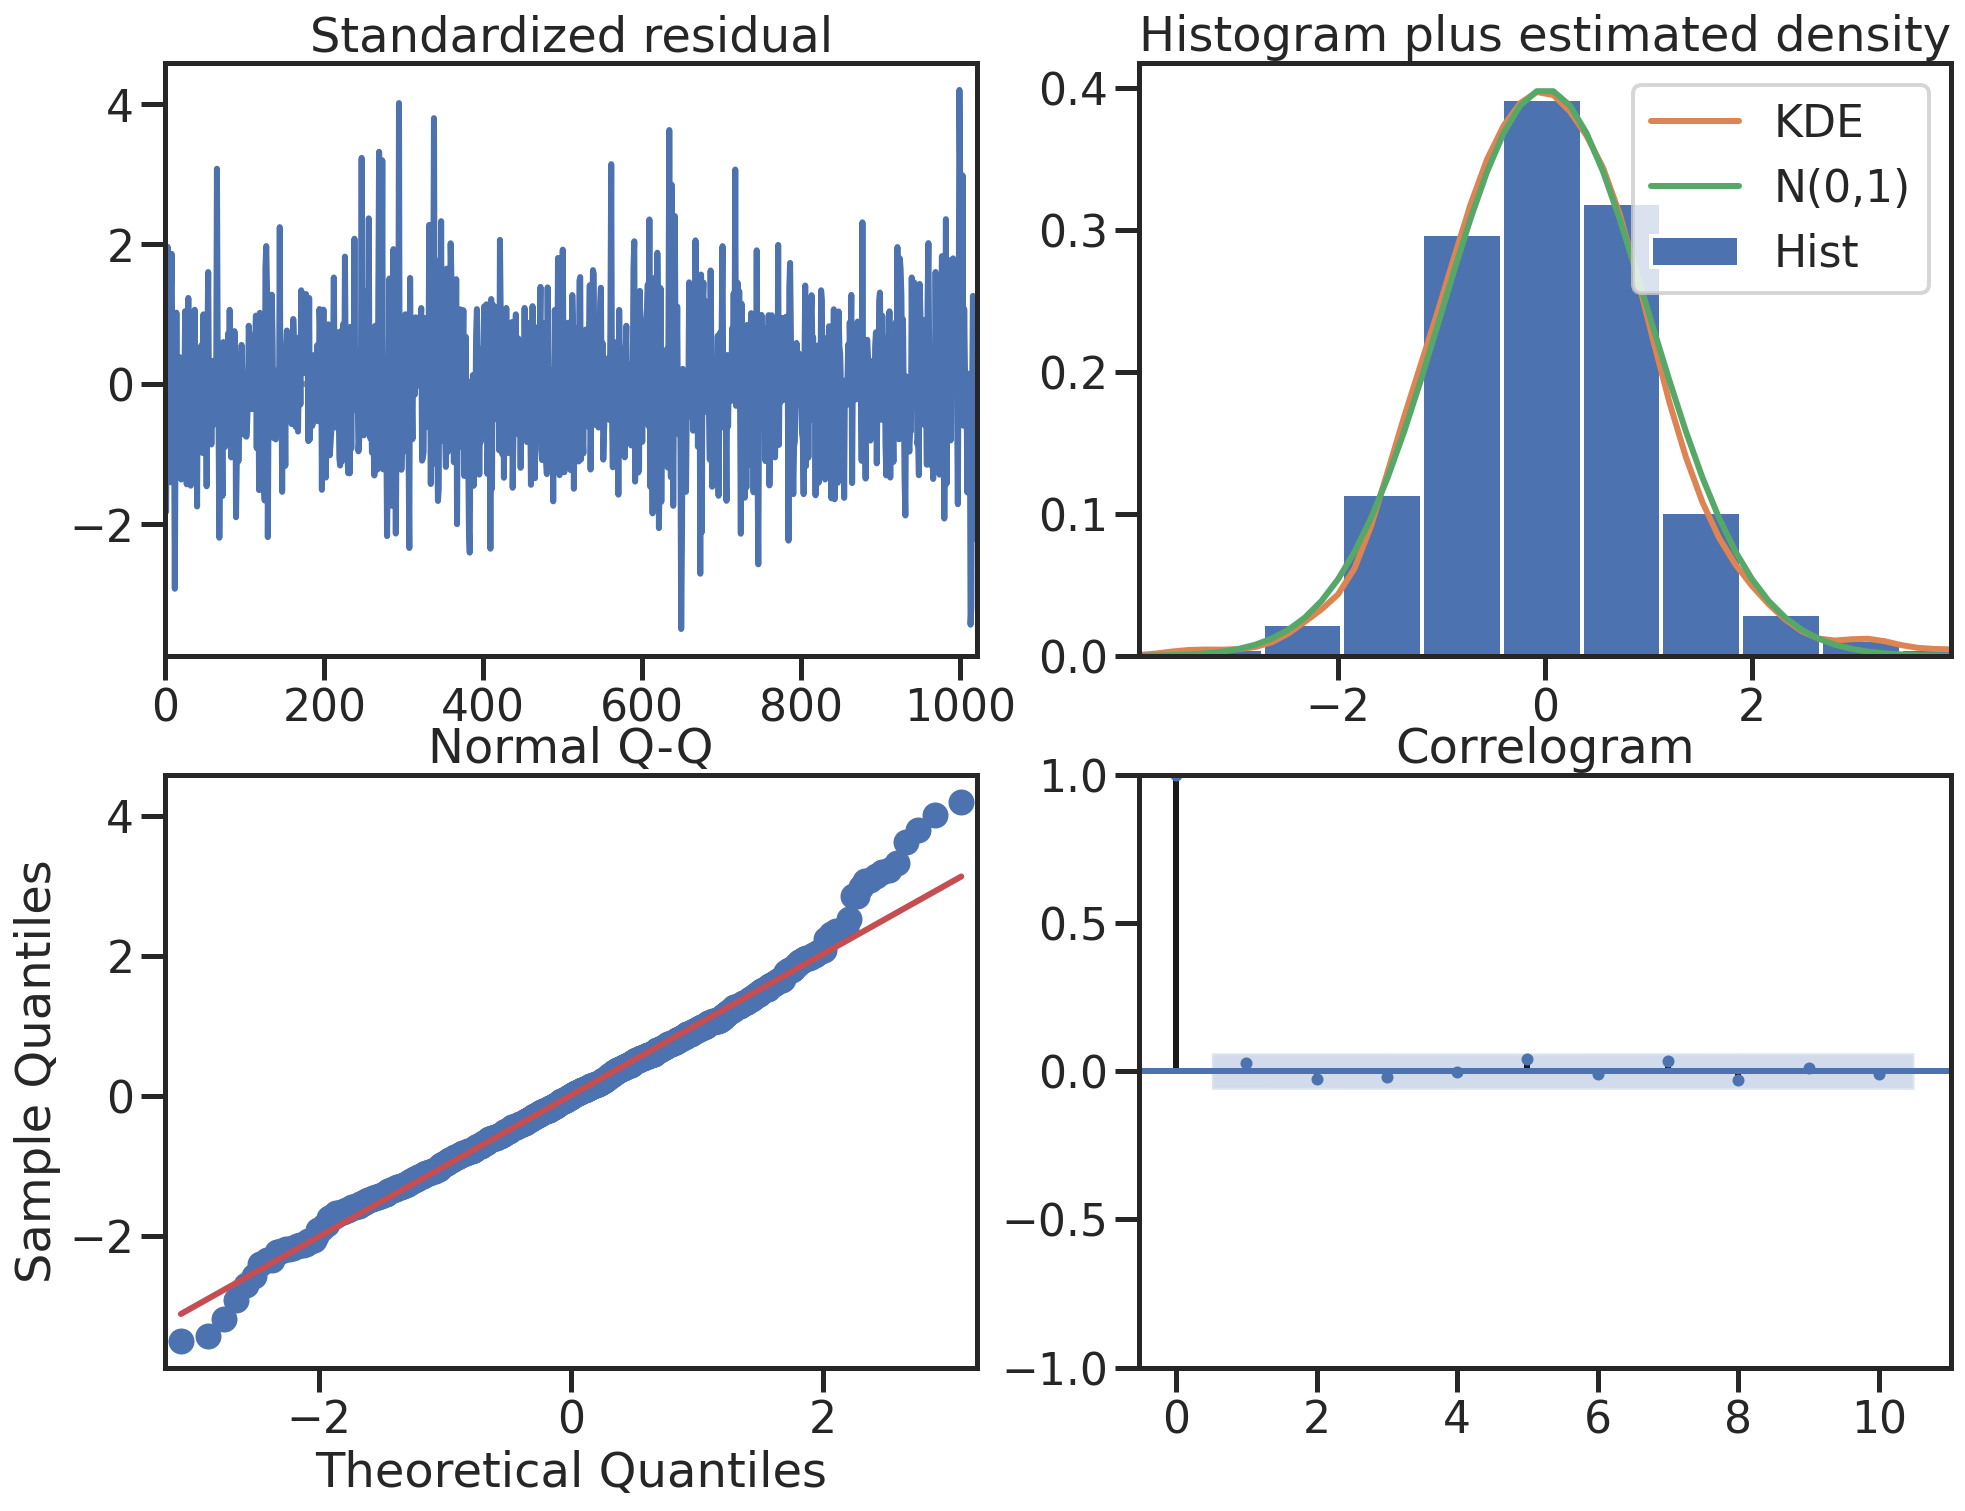

In [ ]:
#Residual analysis, Normal distribution, QQ chart linear, correlogram
model_results.plot_diagnostics(figsize=(16, 12));

1. obtaining the time series data of the observed system.

2. plotting the data and observing whether it is a smooth time series; for non-smooth time series a d-order difference operation is first performed to transform it into a smooth time series.

3. after the second step of processing, has obtained the smooth time series. To obtain the autocorrelation coefficient ACF and the partial autocorrelation coefficient PACF for the smooth time series respectively, the optimal stratum p and order q are obtained by analyzing the autocorrelation and partial autocorrelation plots

4. From the above obtained , the ARIMA model is obtained. The model testing of the obtained model is then started.

In [ ]:
pred = model_results.forecast(steps=446, exog=None, alpha=0.05)
print(pred)
print('2019-04-01:',pred[1462])
print('2019-04-02:',pred[1463])
print('2019-04-03:',pred[1464])
print('2019-04-04:',pred[1465])
print('2019-04-05:',pred[1466])
print('2019-04-06:',pred[1467])
print('2019-04-07:',pred[1468])

1023   68.05805
1024   65.36242
1025   60.73324
1026   64.94125
1027   68.04139
         ...   
1464   65.34404
1465   65.16710
1466   60.30339
1467   62.64257
1468   66.45323
Length: 446, dtype: float64
2019-04-01: 62.410216938098806
2019-04-02: 60.39989880856689
2019-04-03: 65.3440424554246
2019-04-04: 65.16710002626567
2019-04-05: 60.30338507941278
2019-04-06: 62.642573081636044
2019-04-07: 66.45323109415077


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
'''
pred = model_results.forecast(steps=7, exog=None, alpha=0.05)
print(pred)
print('2019-04-01:',pred[0][0])
print('2019-04-02:',pred[0][1])
print('2019-04-03:',pred[0][2])
print('2019-04-04:',pred[0][3])
print('2019-04-05:',pred[0][4])
print('2019-04-06:',pred[0][5])
print('2019-04-07:',pred[0][6])
'''

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


KeyError: ignored